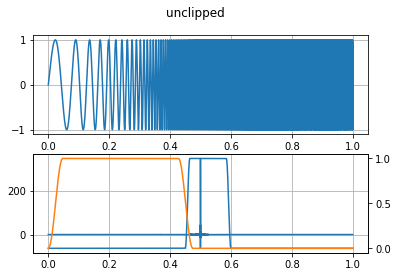

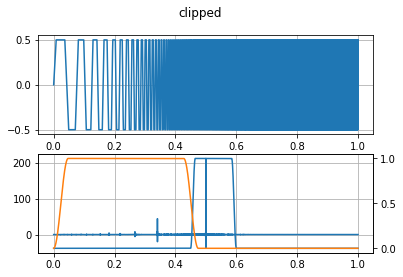

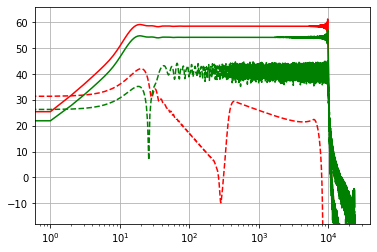

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt


class SweptSineMeas(object):
    def __init__(self, duration, sample_rate, freq_start, freq_stop):
        self.duration = duration
        self.sample_rate = sample_rate
        self.freq_start = freq_start
        self.freq_stop = freq_stop
        self.sample_points = np.arange(0, self.duration, 1 / self.sample_rate)
        self.sweep_rate = np.log(self.freq_stop / self.freq_start)

    @property
    def stimulus(self):
        log_swept_sine = np.sin(
            (2 * np.pi * self.freq_start * self.duration / self.sweep_rate)
            * (np.exp(self.sample_points * self.sweep_rate / self.duration) - 1)
        )
        return log_swept_sine

    @property
    def inverse_filter(self):
        decay_map = np.exp(self.sample_points * self.sweep_rate / self.duration) * 10
        inverse_filter = self.stimulus[::-1] / decay_map
        return inverse_filter

    def _impulse_reponse(self, meas, inverse_filter):
        z = np.zeros((meas.size - inverse_filter.size))
        inverse_filter = np.concatenate((inverse_filter, z))
        impulse_response = sig.fftconvolve(meas, inverse_filter, mode="same")
        return impulse_response

    def _window(
        self,
        points,
        signal_index=None,
        start_time: float = -0.05,
        stop_time: float = 0.1,
        window="hann",
        start_percent=10,
        end_percent=10,
    ) -> np.array:
        if signal_index is None:
            signal_index = int(points / 2)
        start_skirt_points = abs(int(start_time / (1 / self.sample_rate)))
        end_skirt_points = int(stop_time / (1 / self.sample_rate))
        window_points = start_skirt_points + end_skirt_points

        start_skirt = np.zeros(signal_index - start_skirt_points)
        start_window_points = int(window_points * (start_percent / 100))
        start_window = sig.windows.get_window(window, start_window_points * 2)
        start_window = start_window[:start_window_points]

        end_skirt = np.zeros(points - signal_index - end_skirt_points)
        end_window_points = int(window_points * (end_percent / 100))
        end_window = sig.windows.get_window(window, end_window_points * 2)
        end_window = end_window[end_window_points - 1 :: -1]

        middle_window = np.ones(window_points - (start_window.size + end_window.size))
        return np.concatenate((start_skirt, start_window, middle_window, end_window, end_skirt))

    def spectrum_mag(self, meas, window_start, window_stop, plot=False):
        impulse_response = self._impulse_reponse(meas, self.inverse_filter)
        meas_points = np.arange(0, meas.size / self.sample_rate, 1 / self.sample_rate)
        ir_points = np.arange(0, impulse_response.size / self.sample_rate, 1 / self.sample_rate)
        window = self._window(impulse_response.size, start_time=window_start, stop_time=window_stop)

        if plot is True:
            plt.subplot(2, 1, 1)
            plt.grid()
            plt.plot(meas_points, meas)
            plt.subplot(2, 1, 2)
            plt.grid()
            plt.plot(ir_points, impulse_response)
            plt.twinx()
        plt.plot(ir_points, window)

        windowed_meas = impulse_response * window
        mag = np.fft.rfft(windowed_meas)
        freq = np.fft.rfftfreq(windowed_meas.size, 1 / self.sample_rate)

        return freq, 20 * np.log10(np.abs(mag))


if __name__ == "__main__":
    ssm = SweptSineMeas(1, 48000, 10, 10000)
    stim = ssm.stimulus
    meas = stim
    fig = plt.figure()
    fig.suptitle("unclipped")
    freq, fnd_raw = ssm.spectrum_mag(meas, -0.05, 0.1, plot=True)
    freq, dst_raw = ssm.spectrum_mag(meas, -0.5, -0.025)
    meas = np.clip(stim, -0.5, 0.5)
    fig = plt.figure()
    fig.suptitle("clipped")
    freq, fnd_clipped = ssm.spectrum_mag(meas, -0.05, 0.1, plot=True)
    freq, dst_clipped = ssm.spectrum_mag(meas, -0.5, -0.025)
    plt.figure()
    plt.grid()
    plt.semilogx(freq, fnd_raw, "-r")
    plt.semilogx(freq, dst_raw, "--r")
    plt.semilogx(freq, fnd_clipped, "-g")
    plt.semilogx(freq, dst_clipped, "--g")
    plt.ylim([-18, 66])
    plt.show()